In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
import warnings

plt.style.use('ggplot')
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [4]:
df = pd.read_csv('/Users/owup2301/PycharmProjects/ml-zoomcamp/week3/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [7]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [10]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender', 'seniorcitizen', 'partner', 'phoneservice', 'multiplelines', 'internetservice', 'onlinesecurity',
    'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling', 'paymentmethod'
]

In [11]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [13]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8019872249822569

# Accuracy and dummy model

In [14]:
len(y_val)

1409

In [15]:
(y_val == churn_decision).sum()

1130

In [16]:
1130/1409

0.8019872249822569

In [23]:
from sklearn.metrics import accuracy_score

In [26]:
thresholds = np.linspace(0,1,21)

scores = []
for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    scores.append(score)

print(scores)

[0.2739531582682754, 0.5081618168914124, 0.596167494677076, 0.6657203690560681, 0.7068843151171044, 0.7388218594748048, 0.7565649396735273, 0.7679205110007097, 0.7835344215755855, 0.7934705464868701, 0.8019872249822569, 0.8005677785663591, 0.7970191625266146, 0.78708303761533, 0.7636621717530163, 0.7430801987224982, 0.7331440738112136, 0.7260468417317246, 0.7260468417317246, 0.7260468417317246, 0.7260468417317246]


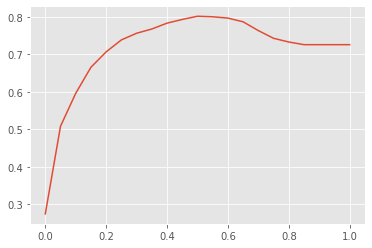

In [27]:
plt.plot(thresholds, scores)
print()

In [28]:
from collections import Counter

In [29]:
Counter(y_pred >= 1.0)

Counter({False: 1409})

# Confusion Table

In [30]:
actual_positive = (y_val ==1)
actual_negative = (y_val == 0)

t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [38]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [39]:
print(tp, tn, fp, fn)

213 917 106 173


In [40]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[917, 106],
       [173, 213]])

In [41]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.08],
       [0.12, 0.15]])

# Precison and Recall

In [42]:
precision = tp / (tp + fp)
precision

0.6677115987460815

In [43]:
recall = tp / (tp + fn)
recall

0.5518134715025906

# ROC Curves

TPR and FPR

In [44]:
tpr = tp / (tp +fn)
fpr = fp / (tn + fp)

print(tpr, fpr)

0.5518134715025906 0.10361681329423265


In [132]:
scores = []
thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    scores.append((t, tp, fp, fn, tn))

ValueError: operands could not be broadcast together with shapes (1409,) (1126,) 

In [47]:
columns = ['threshold', 'tp' ,'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

In [48]:
df_scores

,threshold,tp,fp,fn,tn
0,0.00,386,1023,0,0
1,0.01,385,902,1,121
2,0.02,384,816,2,207
3,0.03,383,758,3,265
4,0.04,381,713,5,310
...,...,...,...,...,...
96,0.96,0,0,386,1023
97,0.97,0,0,386,1023
98,0.98,0,0,386,1023
99,0.99,0,0,386,1023


In [50]:
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
df_scores

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.00,386,1023,0,0,1.000000,1.000000
1,0.01,385,902,1,121,0.997409,0.881720
2,0.02,384,816,2,207,0.994819,0.797654
3,0.03,383,758,3,265,0.992228,0.740958
4,0.04,381,713,5,310,0.987047,0.696970
...,...,...,...,...,...,...,...
96,0.96,0,0,386,1023,0.000000,0.000000
97,0.97,0,0,386,1023,0.000000,0.000000
98,0.98,0,0,386,1023,0.000000,0.000000
99,0.99,0,0,386,1023,0.000000,0.000000


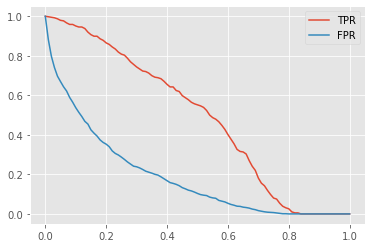

In [52]:
plt.plot(df_scores.threshold, df_scores.tpr, label='TPR')
plt.plot(df_scores.threshold, df_scores.fpr, label='FPR')
plt.legend()
plt.show()

# Random Model

In [55]:
np.random.seed(1)
y_rand = np.random.uniform(0, 2, size=len(y_val))

In [56]:
((y_rand >= 0.5) == y_val).mean()

0.38537970191625265

In [58]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp' ,'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    return df_scores

In [59]:
df_rand = tpr_fpr_dataframe(y_val,y_rand)

In [60]:
df_rand[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,368,966,18,57,0.953368,0.944282
20,0.2,347,923,39,100,0.898964,0.902248
30,0.3,320,875,66,148,0.829016,0.855327
40,0.4,307,822,79,201,0.795337,0.803519
50,0.5,291,771,95,252,0.753886,0.753666
60,0.6,276,724,110,299,0.715026,0.707722
70,0.7,253,670,133,353,0.655440,0.654936
80,0.8,237,624,149,399,0.613990,0.609971
90,0.9,217,571,169,452,0.562176,0.558162


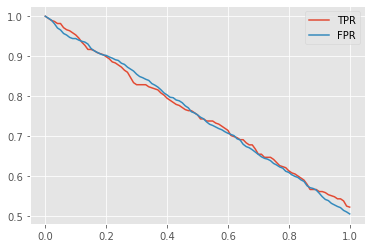

In [61]:
plt.plot(df_rand.threshold, df_rand.tpr, label='TPR')
plt.plot(df_rand.threshold, df_rand.fpr, label='FPR')
plt.legend()
plt.show()

# Ideal model

In [62]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(1023, 386)

In [66]:
y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1])

In [67]:
y_ideal_pred = np.linspace(0,1, len(y_val))

In [68]:
((y_ideal_pred >= 0.726) == y_ideal).mean()

1.0

In [69]:
df_rand_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)

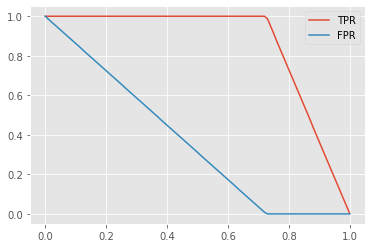

In [70]:
plt.plot(df_rand_ideal.threshold, df_rand_ideal.tpr, label='TPR')
plt.plot(df_rand_ideal.threshold, df_rand_ideal.fpr, label='FPR')
plt.legend()
plt.show()

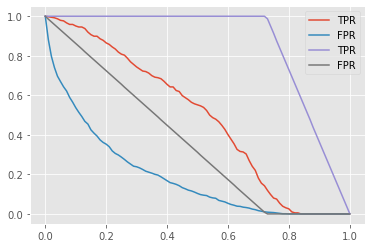

In [72]:
plt.plot(df_scores.threshold, df_scores.tpr, label='TPR')
plt.plot(df_scores.threshold, df_scores.fpr, label='FPR')


plt.plot(df_rand_ideal.threshold, df_rand_ideal.tpr, label='TPR')
plt.plot(df_rand_ideal.threshold, df_rand_ideal.fpr, label='FPR')

plt.legend()
plt.show()

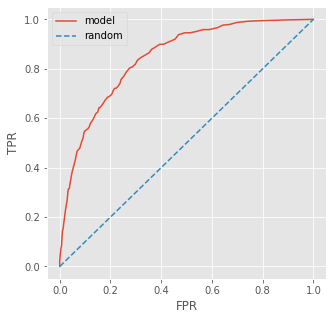

In [78]:
plt.figure(figsize=(5,5))

plt.plot(df_scores.fpr, df_scores.tpr, label='model')
plt.plot([0,1], [0,1], label='random', linestyle='--')
#plt.plot(df_rand.fpr, df_rand.tpr, label='random')
#plt.plot(df_rand_ideal.fpr, df_rand_ideal.tpr, label='ideal')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

In [79]:
from sklearn.metrics import roc_curve

In [80]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

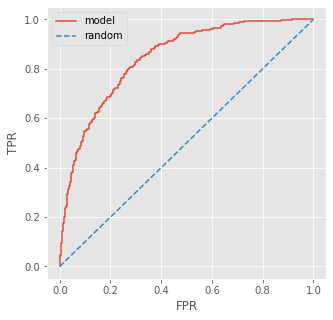

In [81]:
plt.figure(figsize=(5,5))

plt.plot(fpr, tpr, label='model')
plt.plot([0,1], [0,1], label='random', linestyle='--')
#plt.plot(df_rand.fpr, df_rand.tpr, label='random')
#plt.plot(df_rand_ideal.fpr, df_rand_ideal.tpr, label='ideal')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

# ROC AUC

In [82]:
from sklearn.metrics import auc

In [83]:
auc(fpr, tpr)

0.8441442673433314

In [84]:
from sklearn.metrics import roc_auc_score

In [85]:
roc_auc_score(y_val, y_pred)

0.8441442673433314

In [86]:
neg  = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

# Cross-Validation

In [110]:
def train(df, y_train, C=1.0):
    dicts = df[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

In [118]:
df, model = train(df_train, y_train, C=0.001)

In [119]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)

    y_pred = model.predict_proba(X)[:,1]

    return y_pred

In [120]:
y_pred = predict(df_val, dv, model)

In [121]:
from sklearn.model_selection import KFold

In [122]:
%%capture
!pip install tqdm

In [123]:
from tqdm.auto import  tqdm

In [129]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10], total=n_splits):
    scores = []

    kFold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    for train_idx, val_idx in kFold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/5 [00:00<?, ?it/s]

C=0.001 0.825 +- 0.009
C=0.01 0.840 +- 0.009
C=0.1 0.841 +- 0.008
C=0.5 0.841 +- 0.007
C=1 0.841 +- 0.008
C=5 0.841 +- 0.007
C=10 0.841 +- 0.008


In [131]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1)
y_pred = predict(df_test,dv,model)

auc = roc_auc_score(y_test, y_pred)
auc

0.8581107066636332